## 프로젝트:RestNet Ablation Study

평가문항	상세기준
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  

2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.  

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.  

### 1) ResNet 기본 블록 구성하기

ResNet-34와 ResNet-50네트워크의 차이점을 보자.


* 블록 생성하는 함수를 만들자.  
(ResNet-50모델 예제를 살펴보자.)


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=('train[:80%]', 'train[80%:]'), # train으로만 구성된 데이터 셋으로 80%기준 분할
    shuffle_files=True,
    with_info=True,
    as_supervised=True) # as_supervised False인 경우 라벨 인수가 누락되었다는 TypeError:발생


ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

In [4]:
# Input Normalization

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
print("라벨갯수:", ds_info.features["label"].num_classes)
print("라벨명:", ds_info.features["label"].names)
라벨갯수: 2

라벨갯수: 2
라벨명: ['cat', 'dog']


In [6]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [7]:

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                   is_50=True):

    x = input_layer

    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0: 
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    return x

In [8]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=False, 
                 activation='softmax',
                 name='Resnet_34'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    name =''
    if is_50 == False:
        name = 'Resnet-34'
    else:
        name = 'Resnet-50'
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 2) ResNet-34, ResNet-50 Complete Model

In [9]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "Resnet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [10]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "Resnet-50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기

#### 블록 코드 수정하기
1. ResNet의 효과를 보여주기 위해서 skip connection이 없는 plain net을 만들 것이다.

2. 전체 함수 코드 수정하기
각 ResNet-50과 ResNet-34에 skip connection이 없는 Plain-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()을 만든다.  
이미지 사이즈는 (224, 224, 3)으로 설정한다.  


In [11]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [12]:
def build_plainnet(input_shape=(224, 224, 3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [13]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

In [14]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

#### * Ablation Study

In [15]:
BATCH_SIZE = 16
EPOCH = 10

In [16]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [17]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_50')

In [18]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 305s 243ms/step - loss: 2.6390 - accuracy: 0.4981 - val_loss: 1.1779 - val_accuracy: 0.5119
Epoch 2/10
1163/1163 [==============================] - 290s 249ms/step - loss: 0.9197 - accuracy: 0.5020 - val_loss: 31.8296 - val_accuracy: 0.5060
Epoch 3/10
1163/1163 [==============================] - 276s 237ms/step - loss: 0.7980 - accuracy: 0.5322 - val_loss: 0.7275 - val_accuracy: 0.5147
Epoch 4/10
1163/1163 [==============================] - 276s 237ms/step - loss: 0.7564 - accuracy: 0.5468 - val_loss: 0.7509 - val_accuracy: 0.5437
Epoch 5/10
1163/1163 [==============================] - 276s 237ms/step - loss: 0.7615 - accuracy: 0.5433 - val_loss: 0.7680 - val_accuracy: 0.5371
Epoch 6/10
1163/1163 [==============================] - 276s 237ms/step - loss: 0.7757 - accuracy: 0.5367 - val_loss: 0.7330 - val_accuracy: 0.5211
Epoch 7/10
1163/1163 [==============================] - 275s 237ms/step - loss: 0.7930 - accuracy: 0.5337 - val

In [20]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True, 
                          activation='sigmoid',
                          name='Plain_50')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 446s 359ms/step - loss: 3.9665 - accuracy: 0.5096 - val_loss: 77.7735 - val_accuracy: 0.5338
Epoch 2/10
1163/1163 [==============================] - 406s 349ms/step - loss: 2.0054 - accuracy: 0.5266 - val_loss: 1.5292 - val_accuracy: 0.4933
Epoch 3/10
1163/1163 [==============================] - 397s 342ms/step - loss: 1.4615 - accuracy: 0.5329 - val_loss: 1.2654 - val_accuracy: 0.4920
Epoch 4/10
1163/1163 [==============================] - 398s 342ms/step - loss: 1.2604 - accuracy: 0.5632 - val_loss: 1.1573 - val_accuracy: 0.4907
Epoch 5/10
1163/1163 [==============================] - 397s 342ms/step - loss: 1.1415 - accuracy: 0.5187 - val_loss: 1.0142 - val_accuracy: 0.4843
Epoch 6/10
1163/1163 [==============================] - 397s 341ms/step - loss: 1.0083 - accuracy: 0.5136 - val_loss: 0.9059 - val_accuracy: 0.4877
Epoch 7/10
1163/1163 [==============================] - 397s 341ms/step - loss: 0.9179 - accuracy: 0.5358 - val

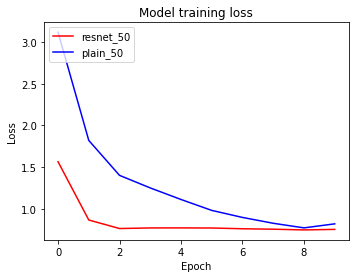

In [22]:
# ResNet-50 vs Plain-50

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()


### 정리
요즘 논문읽기 풀잎스쿨을 하고 있는데, 논문에는 기본적으로 Ablation Study가 들어가 있다. 연구모델에서 기존 것을 빼서 얼마나 효용성이 좋은지를 이를 통해 보여주고 있는데, 이번 노드를 통해 그 과정이 어떻게 진행되어지는지 알 수 있었다.  
커널이 자꾸 죽어서 배치사이즈와 에폭 조절하면서 해결했다만 불만족스럽다.